In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
from scipy.spatial.distance import mahalanobis,euclidean
from sklearn import metrics
from scipy.spatial.distance import mahalanobis
import heapq

# Load data

In [2]:
batch_num = 8
hidden_num = 25
step_num = 10
elem_num = 7
init_wins = 0

names = [str(x) for x in range(elem_num)] +["label"]
forest = pd.read_csv("C:/Users/Bin/Desktop/Thesis/dataset/forest/type1test.csv",names=names,skiprows=step_num*init_wins)
forest_tmp = forest[70000:270000]
forest = pd.concat((forest[:70000],forest[270000:]),axis=0)
forest = pd.concat((forest,forest_tmp),axis=0)
batches = forest.shape[0]//step_num//batch_num
test_set = forest.iloc[:batches*batch_num*step_num,:-1]
labels =forest.iloc[:batches*batch_num*step_num,-1]

ts = test_set.as_matrix().reshape(batches,batch_num,step_num,elem_num)
test_set_list = [ts[a] for a in range(batches)]

In [3]:
labels[labels!="normal"] = "anomaly"

In [4]:
del forest
del test_set

In [5]:
wins = batches * batch_num
# figure out anomaly windows
buffer = [labels[i*step_num:(i+1)*step_num] for i in range(0,labels.size//step_num)]
anomaly_index = []
count = 0
for buf in buffer:
    if "anomaly" in buf.tolist():
        anomaly_index.append(count)
    else:
        pass
    count +=1
print(anomaly_index)

expert = ["normal"]*wins
for x in anomaly_index:
    expert[x] = "anomaly"

[20184, 20185, 20186, 20187, 20188, 20189, 20190, 20191, 20192, 20193, 20194, 20195, 20196, 20197, 20198, 20199, 20200, 20201, 20202, 20203, 20204, 20205, 20206, 20207, 20208, 20209, 20210, 20211, 20212, 20213, 20214, 20215, 20216, 20217, 20218, 20219, 20220, 20221, 20222, 20223, 20224, 20225, 20226, 20227, 20228, 20229, 20230, 20231, 20232, 20233, 20234, 20235, 20236, 20237, 20238, 20239, 20240, 20241, 20242, 20243, 20244, 20245, 20246, 20247, 20248, 20249, 20250, 20251, 20252, 20253, 20254, 20255, 20256, 20257, 20258, 20259, 20260, 20261, 20262, 20263, 20264, 20265, 20266, 20267, 20268, 20269, 20270, 20271, 20272, 20273, 20274, 20275, 20276, 20277, 20278, 20279, 20280, 20281, 20282, 20283, 20284, 20285, 20286, 20287, 20288, 20289, 20290, 20291, 20292, 20293, 20294, 20295, 20296, 20297, 20298, 20299, 20300, 20301, 20302, 20303, 20304, 20305, 20306, 20307, 20308, 20309, 20310, 20311, 20312, 20313, 20314, 20315, 20316, 20317, 20318, 20319, 20320, 20321, 20322, 20323, 20324, 20325, 20326

# Load Model

In [6]:
modelpath_root ="C:/Users/Bin/Desktop/Thesis/models/forest_8_25_10/"
modelmeta_p = modelpath_root + "_8_25_10_para.ckpt.meta"

sess = tf.Session()
saver = tf.train.import_meta_graph(modelmeta_p) # load trained gragh, but without the trained parameters
saver.restore(sess,tf.train.latest_checkpoint(modelpath_root))
graph = tf.get_default_graph()

p_input = graph.get_tensor_by_name("p_input:0")
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)] 
p_is_training = graph.get_tensor_by_name("is_training_:0")

input_= tf.transpose(tf.stack(p_inputs), [1, 0, 2])    
output_ = graph.get_tensor_by_name("decoder/output_:0")

tensor_mu = graph.get_tensor_by_name("mu:0")
tensor_sigma = graph.get_tensor_by_name("sigma:0")
tensor_threshold = graph.get_tensor_by_name("threshold:0")

loss_ = graph.get_tensor_by_name("decoder/loss:0")
train_ = graph.get_operation_by_name("cond/train_")

mu = sess.run(tensor_mu)
sigma = sess.run(tensor_sigma)
threshold = sess.run(tensor_threshold)

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/models/forest_8_25_10/_8_25_10_para.ckpt


In [7]:
print(mu.shape,sigma.shape,threshold)

(7,) (7, 7) 0.00652888


# Online Phase (With expert)

In [8]:
def local_preprocessing(batchdata):
    # input batchdata with shape : [batch_num, step_num, elem_num]
    # minmax scaler on window level
    df = pd.DataFrame()
    
    for window in batchdata:
        
        scaler = MinMaxScaler()
        scaler.fit(window)
        new_win = scaler.transform(window)
        df = pd.concat((df, pd.DataFrame(new_win)),axis=0) if df.size!=0 else pd.DataFrame(new_win)
    return df.as_matrix().reshape(batchdata.shape)

    

In [9]:
def scoring(err,mu,sigma):
    
    scores = []
    for e in err:
        scores.append(mahalanobis(e,mu,sigma))

    return scores

In [10]:
def get_musigma(err_nbuf,mu,sigma):       
    
        err_vec_array = np.array(err_nbuf)
        # for multivariate  data
        mu = np.mean(err_vec_array,axis=0)
        sigma = np.cov(err_vec_array.T)
        return mu, sigma

In [11]:
def get_threshold(normal_score, abnormal_score):
        upper = np.median(np.array(abnormal_score))
        lower = np.median(np.array(normal_score)) 
        scala = 20
        delta = (upper-lower) / scala
        candidate = lower
        threshold = 0
        result = 0

        def evaluate(threshold,normal_score,abnormal_score):

            beta = 0.5
            tp = np.array(abnormal_score)[np.array(abnormal_score)>threshold].size
            fp = len(abnormal_score)-tp
            fn = np.array(normal_score)[np.array(normal_score)>threshold].size
            tn = len(normal_score)- fn

            if tp == 0: return 0

            P = tp/(tp+fp)
            R = tp/(tp+fn)
            fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
            return fbeta 

        for _ in range(scala):
            r = evaluate(candidate,normal_score,abnormal_score)
            if r > result:
                result = r 
                threshold = candidate
            candidate += delta 
        return threshold

In [12]:
def plot_roc(fpr,tpr,auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' %auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
count = 0
n_buf = []
a_buf = []

y = []
output=[]
err_nbuf = []
err_abuf = []
all_scores = []

start_time = time.time()
for l in labels:
    if l == "normal":
        y +=[0]
    else: 
        y +=[1]
for data in test_set_list:
        if count % 100 == 0:
            print(count)
            
        prediction = []
        df = local_preprocessing(data)
        (input_n, output_n) = sess.run([input_, output_], {p_input: df, p_is_training: False})

        err = abs(input_n-output_n).reshape(-1,elem_num)
        
  
        scores = scoring(err,mu,sigma) # (8*30,)
        #scores = pd.Series(scores)
        
        all_scores.append(scores)
        output +=  [np.array(heapq.nlargest(10,ss)).mean() for ss in np.array(scores).reshape(batch_num,step_num)]
#        output += [ss.max() for ss in np.array(scores).reshape(batch_num,step_num)]
        pred = [scores[b*step_num:(b+1)*step_num] for b in range(batch_num)]  # (8,30)
        
        label = [expert[count*batch_num+b] for b in range(batch_num)]
        e = err
        
#       for index,value in enumerate(pd.DataFrame(pred)):
        for i in range(pd.DataFrame(pred).shape[0]):#loop batch_num
            index = i
            value=pd.DataFrame(pred).iloc[i,:]
            
            if value[value>threshold].size>=1: 
                if label[index] == "anomaly":
                    #print("TP")                 
                    a_buf += [df[index,x,:] for x in range(step_num)]
                    #err_abuf.append(e[index*step_num:(index+1)*step_num])
                    err_abuf = np.concatenate((err_abuf , e[index*step_num:(index+1)*step_num]),axis=0) if len(err_abuf) != 0 else e[index*step_num:(index+1)*step_num]
                else:
                    #print("FP")
                    #err_nbuf.append(e[index])
                    err_nbuf =np.concatenate((err_nbuf , e[index*step_num:(index+1)*step_num]),axis=0) if len(err_nbuf) != 0 else e[index*step_num:(index+1)*step_num]
                    
                    n_buf += [df[index,x,:] for x in range(step_num)]
            else:               
                if label[index] == "anomaly":             
                    #print("FN")
                    a_buf += [df[index,x,:] for x in range(step_num)]
                    #err_abuf.append(e[index])
                    err_abuf = np.concatenate((err_abuf , e[index*step_num:(index+1)*step_num]),axis=0) if len(err_abuf) != 0 else e[index*step_num:(index+1)*step_num]
                else:
                    
                    #err_nbuf.append(e[index])
                    err_nbuf = np.concatenate((err_nbuf , e[index*step_num:(index+1)*step_num]),axis=0) if len(err_nbuf) != 0 else e[index*step_num:(index+1)*step_num]
                    #print("TN")
        count +=1
        
        
        #n_buf = list(np.concatenate(n_buf,axis=0)) if len(n_buf) != 0 else list(n_buf)
        #a_buf = list(np.concatenate(a_buf,axis=0)) if len(a_buf) != 0 else list(a_buf)
        
        if len(n_buf)>=batch_num*step_num*100 and len(a_buf) !=0:
            while (len(a_buf) < batch_num*step_num):
                a_buf += a_buf
            
            B = len(n_buf) //(batch_num*step_num)
            n_buf = n_buf[:batch_num*step_num*B]
            A = len(a_buf)//(batch_num*step_num)
            a_buf = a_buf[:batch_num*step_num*A]
            
            print("retrain at %d batch"%count)
            loss_list_all=[]

            #datalist = np.array(n_buf).reshape(-1,batch_num,step_num,elem_num)
            datalist = np.array(n_buf[:batch_num*step_num*(B-1)]).reshape(-1,batch_num,step_num,elem_num)
            validation_list_n = np.array(n_buf[batch_num*step_num*(B-1):]).reshape(-1,batch_num,step_num,elem_num)
            validation_list_a = np.array(a_buf).reshape(-1,batch_num,step_num,elem_num)
            
            for i in range(30):
                loss_list=[]
                for data in datalist:
                    (loss, _) = sess.run([loss_, train_], {p_input: data,p_is_training : True})
                    loss_list.append(loss)
                #print('Retrain-iter %d:' % (i + 1), np.array(loss_list).mean())
                loss_list_all.append( np.array(loss_list).mean()) 
            
            #err_nbuf_tmp = np.array(err_nbuf).reshape(-1,elem_num)
            #mu,sigma = get_musigma(err_nbuf_tmp,mu,sigma)   

      

            print("Parameters updated! new threshold %.3f"%threshold)
            pd.Series(loss_list_all).plot(title="Loss")
            n_buf = []
            a_buf = []
            err_buf = []
            err_nbuf = []
            err_abuf = []
                
fpr, tpr, thresholds = metrics.roc_curve(expert, output, pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

plt.show()
print("--- Initialization time: %s seconds ---" % (time.time() - start_time))

0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
retrain at 2524 batch


0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500


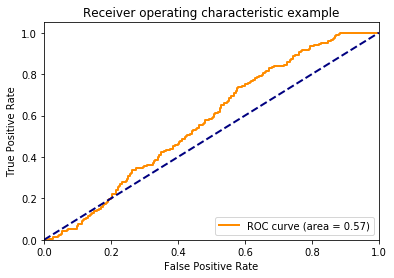

In [18]:
count = 0
n_buf = []
a_buf = []

y = []
output=[]
err_nbuf = []
err_abuf = []
all_scores = []


for l in labels:
    if l == "normal":
        y +=[0]
    else: 
        y +=[1]
for data in test_set_list:
        if count % 100 == 0:
            print(count)
            
        prediction = []
        df = local_preprocessing(data)
        (input_n, output_n) = sess.run([input_, output_], {p_input: df, p_is_training: False})

        err = abs(input_n-output_n).reshape(-1,elem_num)
        
  
        scores = scoring(err,mu,sigma) # (8*30,)
        #scores = pd.Series(scores)
        
        all_scores.append(scores)
#        output +=  [np.array(heapq.nlargest(10,ss)).mean() for ss in scores.as_matrix().reshape(batch_num,step_num)]
        output += [ss.max() for ss in np.array(scores).reshape(batch_num,step_num)]
        pred = [scores[b*step_num:(b+1)*step_num] for b in range(batch_num)]  # (8,30)
        
        label = [expert[count*batch_num+b] for b in range(batch_num)]
        e = err
        
#       for index,value in enumerate(pd.DataFrame(pred)):
        for i in range(pd.DataFrame(pred).shape[0]):#loop batch_num
            index = i
            value=pd.DataFrame(pred).iloc[i,:]
            
            if value[value>threshold].size>=5: 
                if label[index] == "anomaly":
                    #print("TP")                 
                    a_buf += [df[index,x,:] for x in range(step_num)]
                    #err_abuf.append(e[index*step_num:(index+1)*step_num])
                    err_abuf = np.concatenate((err_abuf , e[index*step_num:(index+1)*step_num]),axis=0) if len(err_abuf) != 0 else e[index*step_num:(index+1)*step_num]
                else:
                    #print("FP")
                    #err_nbuf.append(e[index])
                    err_nbuf =np.concatenate((err_nbuf , e[index*step_num:(index+1)*step_num]),axis=0) if len(err_nbuf) != 0 else e[index*step_num:(index+1)*step_num]
                    
                    n_buf += [df[index,x,:] for x in range(step_num)]
            else:               
                if label[index] == "anomaly":             
                    #print("FN")
                    a_buf += [df[index,x,:] for x in range(step_num)]
                    #err_abuf.append(e[index])
                    err_abuf = np.concatenate((err_abuf , e[index*step_num:(index+1)*step_num]),axis=0) if len(err_abuf) != 0 else e[index*step_num:(index+1)*step_num]
                else:
                    
                    #err_nbuf.append(e[index])
                    err_nbuf = np.concatenate((err_nbuf , e[index*step_num:(index+1)*step_num]),axis=0) if len(err_nbuf) != 0 else e[index*step_num:(index+1)*step_num]
                    #print("TN")
        count +=1
        
        
        #n_buf = list(np.concatenate(n_buf,axis=0)) if len(n_buf) != 0 else list(n_buf)
        #a_buf = list(np.concatenate(a_buf,axis=0)) if len(a_buf) != 0 else list(a_buf)

        if len(n_buf)>=batch_num*step_num*50000000 and len(a_buf) !=0:
            while (len(a_buf) < batch_num*step_num):
                a_buf += a_buf
            
            B = len(n_buf) //(batch_num*step_num)
            n_buf = n_buf[:batch_num*step_num*B]
            A = len(a_buf)//(batch_num*step_num)
            a_buf = a_buf[:batch_num*step_num*A]
            
            print("retrain at %d batch"%count)
            loss_list_all=[]

            #datalist = np.array(n_buf).reshape(-1,batch_num,step_num,elem_num)
            datalist = np.array(n_buf[:batch_num*step_num*(B-1)]).reshape(-1,batch_num,step_num,elem_num)
            validation_list_n = np.array(n_buf[batch_num*step_num*(B-1):]).reshape(-1,batch_num,step_num,elem_num)
            validation_list_a = np.array(a_buf).reshape(-1,batch_num,step_num,elem_num)
            
            for i in range(30):
                print(i)
                loss_list=[]
                for data in datalist:
                    (loss, _) = sess.run([loss_, train_], {p_input: data,p_is_training : True})
                    loss_list.append(loss)
                #print('Retrain-iter %d:' % (i + 1), np.array(loss_list).mean())
                loss_list_all.append( np.array(loss_list).mean()) 
            
            err_nbuf_tmp = np.array(err_nbuf).reshape(-1,elem_num)
            mu,sigma = get_musigma(err_nbuf_tmp,mu,sigma)

      

            print("Parameters updated! new threshold %.3f"%threshold)
            pd.Series(loss_list_all).plot(title="Loss")
            n_buf = []
            a_buf = []
            err_buf = []
            err_nbuf = []
            err_abuf = []
                
fpr, tpr, thresholds = metrics.roc_curve(expert, output, pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

plt.show()

In [50]:
foo = [1674, 1699, 1724, 1773, 1796, 1892, 1986, 2055, 2078, 2101, 2150, 2199, 2225, 2275, 2302, 2357, 2438, 2467, 2559, 2684, 2686, 2711, 2716, 2741, 2744, 2746, 2747, 2772, 2776, 2806, 2835, 2860, 2864, 2891, 2918, 2922, 2946, 2949, 2950, 2976, 2978, 3004, 3027, 3031, 3032, 3058, 3080, 3083, 3084, 3110, 3134, 3135, 3138, 3139, 3158, 3159, 3163, 3164, 3181, 3182, 3183]

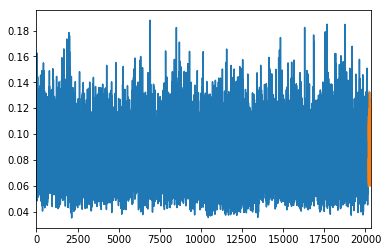

In [20]:
pd.Series(output).plot()
pd.Series(output)[anomaly_index].plot()

In [16]:
len(test_set_list)


160

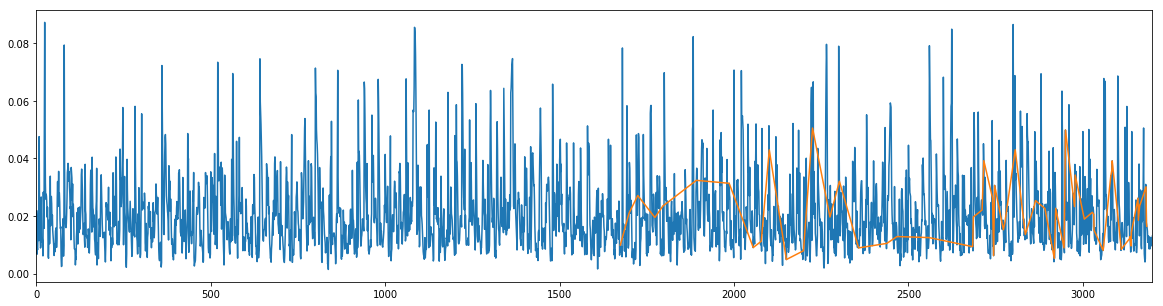

In [54]:
pd.Series(np.array(all_scores).ravel()).plot(figsize=(20,5))
pd.Series(np.array(all_scores).ravel())[foo].plot()

# Without retraining

In [17]:
count = 0
n_buf = []
a_buf = []

y = []
output=[]
box = []
err_nbuf = []
err_abuf = []
all_scores = []

for l in labels:
    if l == "normal":
        y +=[0]
    else: 
        y +=[1]
for data in test_set_list:
    
        prediction = []
        df = local_preprocessing(data)
        (input_n, output_n) = sess.run([input_, output_], {p_input: df, p_is_training: False})

        err = abs(input_n-output_n).reshape(-1,elem_num)
        
        box.append(err.reshape(-1,))
        
        scores = scoring(err,mu,sigma)
        scores = pd.Series(scores)
        
        all_scores.append(scores)
        output +=  [np.array(heapq.nlargest(10,scores)).mean()]
#        output += [scores.max()]
        pred = [scores[b*step_num:(b+1)*step_num] for b in range(batch_num)]
        label = [expert[count*batch_num+b]for b in range(batch_num)]
        e = [err.reshape(-1,elem_num)]
        for index,value in enumerate(pred):
            if value[value>threshold].size>=20: 
                if label[index] == "anomaly":
                    #print("TP")                 
                    a_buf.append(df[index])
                    err_abuf.append(e[index])
                    #err_abuf = err_abuf + e[index] if len(err_abuf) != 0 else e[index]
                else:
                    #print("FP")
                    err_nbuf.append(e[index])
                    #err_nbuf = err_nbuf + e[index] if len(err_nbuf) != 0 else e[index]
                    n_buf.append(df[index])
            else:               
                if label[index] == "anomaly":             
                    #print("FN")
                    a_buf.append(df[index])
                    err_abuf.append(e[index])
                    #err_abuf = err_abuf + e[index] if len(err_abuf) != 0 else e[index]
                else:
                    err_nbuf.append(e[index])
                    #err_nbuf = err_nbuf + e[index] if len(err_nbuf) != 0 else e[index]
                    #print("TN")
        count +=1
        

fpr, tpr, thresholds = metrics.roc_curve(expert, output, pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


IndexError: list index out of range

In [41]:
foo = pd.Series(np.array(output).ravel())

In [42]:
bar = pd.Series(expert)

In [43]:
bar[bar!="normal"].shape

(271,)

In [44]:
foo[bar=="normal"].mean()

0.06917340944129498

In [45]:
foo[bar!="normal"].mean()

0.0876076409210934

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


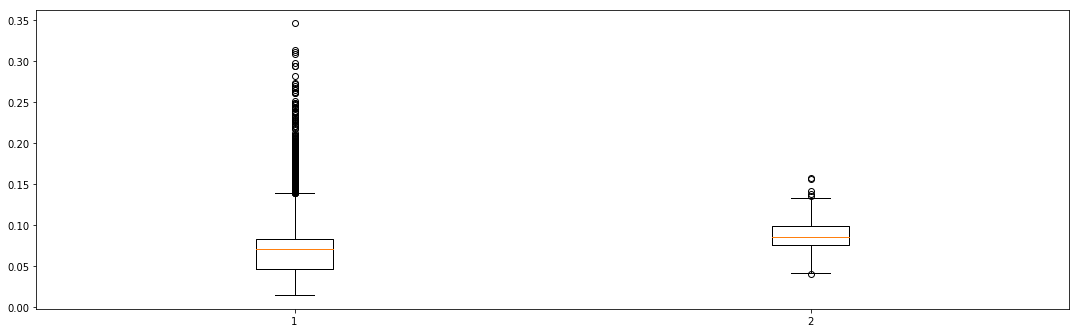

In [46]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 5.5)
ax.boxplot([foo[bar=="normal"],foo[bar!="normal"]])

plt.show()

In [47]:
bar.plot()

TypeError: Empty 'DataFrame': no numeric data to plot

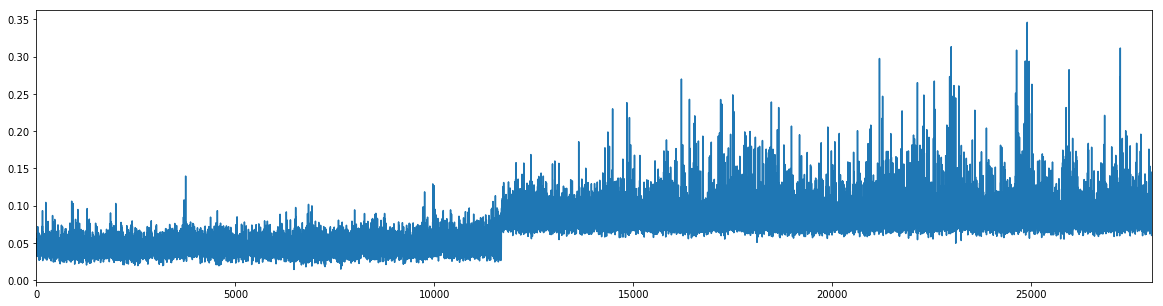

In [62]:
foo.plot(figsize=(20,5))

In [55]:
forest.iloc[:,-1].unique()

array(['normal', 'abnormal'], dtype=object)

In [57]:
forest_test = pd.read_csv("C:/Users/Bin/Documents/Datasets/forest cover/covtype.data",header=None)

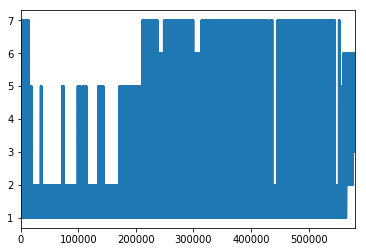

In [61]:
forest_test.iloc[:,-1].plot()